In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
%cd '/content/drive/MyDrive/Speech-Recognition'
%ls

/content/drive/MyDrive/Speech-Recognition
 best_model.h5   best_model.hdf5   input/  'Speech Recognition.ipynb'


# Lấy dữ liệu


In [25]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")
train_audio_path = 'input/train_split/'
labels=os.listdir(train_audio_path)

remove_text = '.ipynb_checkpoints'
if remove_text in labels : 
  labels.remove('.ipynb_checkpoints')
size_test = len(labels)

[50, 50, 50, 50, 50, 50, 50]


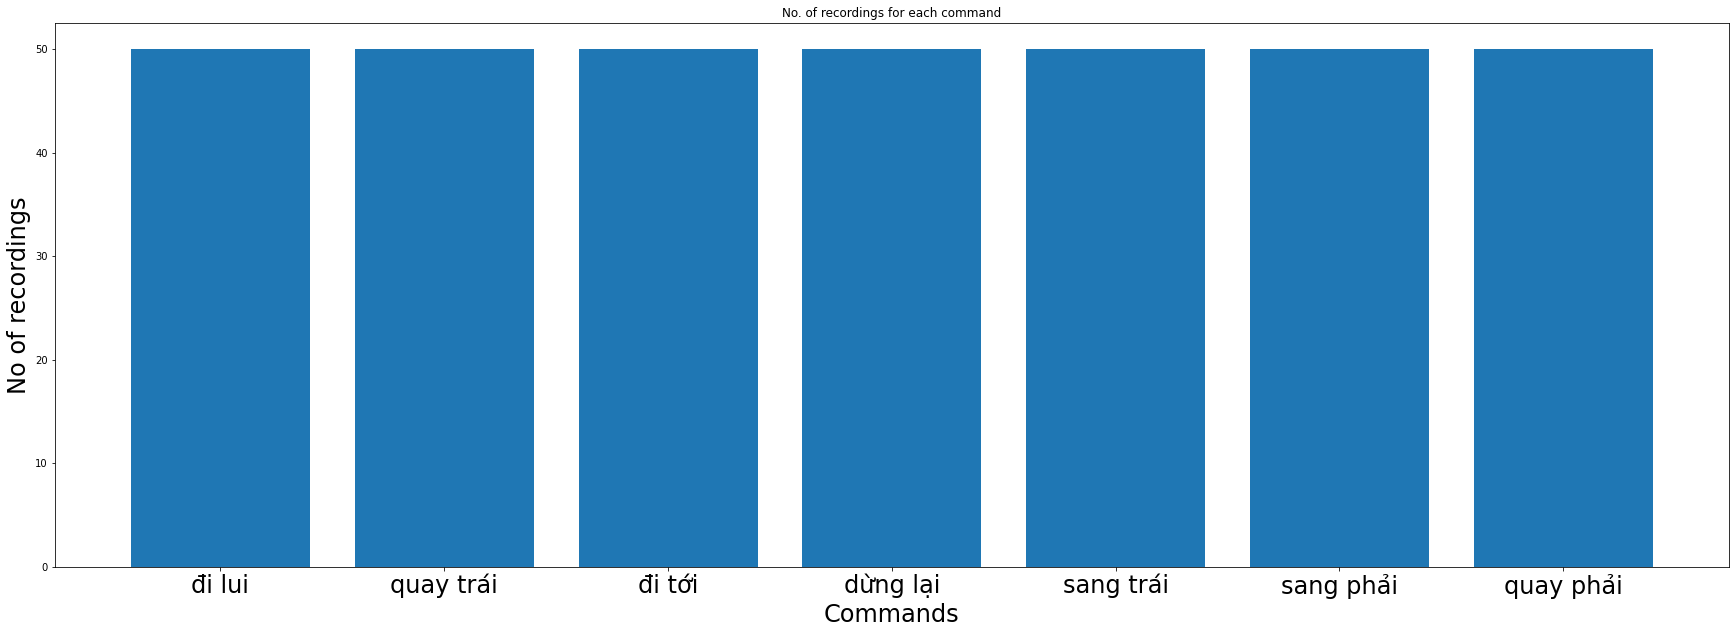

In [26]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,10))
index = np.arange(len(labels))
print(no_of_recordings)
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=24)
plt.ylabel('No of recordings', fontsize=24)
plt.xticks(index, labels, fontsize=24, rotation=0)
plt.title('No. of recordings for each command')
plt.show()

**Duration of recordings**

Độ dài file ghi âm 

In [27]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

# **Dữ liệu Train**

In [28]:
shape = 31951

In [35]:
all_wave = []
all_label = []
for label in labels:
  print(label)
  waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
  for wav in waves:
    samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 44100)
    samples = librosa.resample(samples, sample_rate, 8000)
    if len(samples) < shape : 
        fill = [0] * (shape - len(samples))
        samples = np.concatenate((samples,fill))

        wn = np.random.randn(shape)
        samples_wn = samples + 0.005*wn
        all_wave.append(samples)
        all_label.append(label)
        
        wn = np.random.randn(shape)
        samples_wn = samples + 0.005*wn
        all_wave.append(samples_wn)
        all_label.append(label)

        wn = np.random.randn(shape)
        samples_wn = samples + 0.005*wn
        all_wave.append(samples_wn)
        all_label.append(label)

    else : 
        all_wave.append(samples)
        all_label.append(label)
        
        wn = np.random.randn(shape)
        samples_wn = samples + 0.005*wn
        all_wave.append(samples_wn)
        all_label.append(label)

        wn = np.random.randn(shape)
        samples_wn = samples + 0.005*wn
        all_wave.append(samples_wn)
        all_label.append(label)

đi lui
quay trái
đi tới
dừng lại
sang trái
sang phải
quay phải


Convert the output labels to integer

In [36]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
y=np_utils.to_categorical(y, num_classes=len(labels))

classes

['dừng lại',
 'quay phải',
 'quay trái',
 'sang phải',
 'sang trái',
 'đi lui',
 'đi tới']

## Create input shape

In [37]:
input_shape = (shape,1)

In [38]:
all_wave = np.array(all_wave).reshape(-1,shape,1) # shape same with len of sample 

## Create Model 

In [39]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=input_shape) # Input shape has len same with data
dropout_rate = 0.3
max_pooling = 3

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(max_pooling)(conv)
conv = Dropout(dropout_rate)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(max_pooling)(conv)
conv = Dropout(dropout_rate)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(max_pooling)(conv)
conv = Dropout(dropout_rate)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(max_pooling)(conv)
conv = Dropout(dropout_rate)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(dropout_rate)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(dropout_rate)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31951, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 31939, 8)          112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10646, 8)          0         
_________________________________________________________________
dropout (Dropout)            (None, 10646, 8)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10636, 16)         1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3545, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3545, 16)          0     

## Train Validation Test

**Split into train and validation set**

Train the model on 80% of the data and validate on the remaining 20%:

Test size is 0.2 that means 20%


In [40]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.3, random_state=1, shuffle=True)

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [41]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, 
                   patience= 20, min_delta=0.0001) # kết thúc sớm với 20 giá trị giống nhau thì ngắt
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', 
                     verbose=1, save_best_only=True, mode='max')

### **Train dữ liệu thu được**

In [42]:
history=model.fit(x_tr, y_tr ,epochs = 200, callbacks=[es,mc], batch_size = 32, validation_data=(x_val,y_val))

Epoch 1/200
23/23 [==============================] - 2s 36ms/step - loss: 1.9479 - accuracy: 0.1573 - val_loss: 1.9217 - val_accuracy: 0.2254

Epoch 00001: val_accuracy improved from -inf to 0.22540, saving model to best_model.hdf5
Epoch 2/200
23/23 [==============================] - 0s 22ms/step - loss: 1.8557 - accuracy: 0.2722 - val_loss: 1.9115 - val_accuracy: 0.2476

Epoch 00002: val_accuracy improved from 0.22540 to 0.24762, saving model to best_model.hdf5
Epoch 3/200
23/23 [==============================] - 1s 22ms/step - loss: 1.8052 - accuracy: 0.2766 - val_loss: 1.8400 - val_accuracy: 0.3175

Epoch 00003: val_accuracy improved from 0.24762 to 0.31746, saving model to best_model.hdf5
Epoch 4/200
23/23 [==============================] - 1s 22ms/step - loss: 1.6453 - accuracy: 0.3720 - val_loss: 1.7990 - val_accuracy: 0.3302

Epoch 00004: val_accuracy improved from 0.31746 to 0.33016, saving model to best_model.hdf5
Epoch 5/200
23/23 [==============================] - 0s 22ms/st

##Trực quan hóa dữ liệu sau khi Train/Test


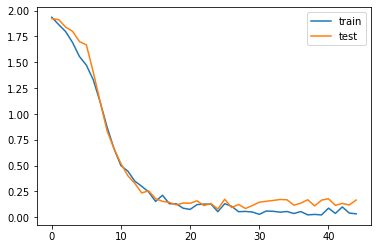

In [43]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

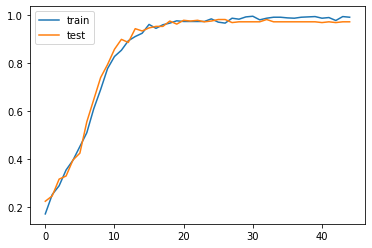

In [44]:
from matplotlib import pyplot 
pyplot.plot(history.history['accuracy'], label='train') 
pyplot.plot(history.history['val_accuracy'], label='test') 
pyplot.legend() 
pyplot.show()

# Test


## **Loading the best model**

In [45]:
from keras.models import load_model
model=load_model('best_model.hdf5')

Define the function that predicts text for the given audio:

In [46]:
def predict(audio):
    prob=model.predict(audio.reshape(1,shape,1))  # same len of data
    index=np.argmax(prob[0])
    return classes[index]

***Prediction*** :  Make predictions on the validation data: ( Dự đoán )


In [47]:
filepath='input/voice-commands/test'
waves = [f for f in os.listdir(filepath + '/') if f.endswith('.wav')]
for wav in waves:
    samples, sample_rate = librosa.load(filepath + '/' + wav, sr = 44100)
    samples = librosa.resample(samples, sample_rate, 8000)
    data  = []
    if len(samples.shape) == 2:
        if samples.shape[1] !=  1 :
            for i in range(len(samples)):
                data.append(samples[i][1])
    else : 
        data = samples

    print(wav + " = " + predict(data))

ditoi_tue_03.wav = đi tới
dunglai_tue_05.wav = dừng lại
sangphai_tue_05.wav = sang phải
dilui_tue_06.wav = đi lui
sangtrai_tue_03.wav = sang trái
quayphai_tue_09.wav = quay phải
quaytrai_tue_07.wav = quay trái
dilui_DLN_05.wav = đi lui
dunglai_DLN_06.wav = dừng lại
ditoi_DLN_03.wav = đi tới
quaytrai_DLN_04.wav = quay trái
quayphai_DLN_04.wav = quay phải
sangphai_DLN_01.wav = sang phải
sangphai_DLN_06.wav = sang phải
sangtrai_DLN_04.wav = sang trái
ditoi_Dat_07.wav = đi tới
dilui_Dat_10.wav = đi lui
dunglai_Dat_04.wav = dừng lại
quayphai_Dat_05.wav = quay phải
quaytrai_Dat_05.wav = quay trái
sangtrai_Dat_05.wav = sang trái
